In [99]:
import os
import sys

import torch
import torchvision
from torchvision.utils import save_image
from torch import nn
from torch import optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TODO: Fix sibling directory imports
cwd = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(cwd, '..'))

from src.datautils.sandia import SandiaDataProvider
from src.utils import show_batch_of_images
from src.autoencoders import MLP_autoencoder

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [112]:
img_size = 28

train_data = SandiaDataProvider(which_set='train',
                                  dataset_home='../../datasets/sandia/',
                                  img_size=img_size)
test_data = SandiaDataProvider(which_set='test',
                                  dataset_home='../../datasets/sandia/',
                                  img_size=img_size,
                                  normalize_mean=train_data.normalize_mean,
                                  normalize_sd=train_data.normalize_sd)
test_inputs = test_data.inputs.transpose(3, 0, 1, 2).reshape(-1, img_size ** 2)

# Our autoencoder on our data

Training for lr=1e-10, momentum=0.0
epoch [1/10], loss:0.8800
epoch [2/10], loss:0.9550
epoch [3/10], loss:0.8484
epoch [4/10], loss:1.7266
epoch [5/10], loss:0.9912
epoch [6/10], loss:0.7928
epoch [7/10], loss:1.1964
epoch [8/10], loss:0.8118
epoch [9/10], loss:0.9538
epoch [10/10], loss:0.9758
Test loss: 1.136
Training for lr=1e-10, momentum=0.1
epoch [1/10], loss:0.7166
epoch [2/10], loss:0.8394
epoch [3/10], loss:1.0944
epoch [4/10], loss:1.2088
epoch [5/10], loss:0.8339
epoch [6/10], loss:0.8820
epoch [7/10], loss:0.9135
epoch [8/10], loss:0.9249
epoch [9/10], loss:0.8913
epoch [10/10], loss:0.9545
Test loss: 1.135
Training for lr=1e-09, momentum=0.0
epoch [1/10], loss:1.3592
epoch [2/10], loss:0.6746
epoch [3/10], loss:1.4686
epoch [4/10], loss:1.1400
epoch [5/10], loss:0.8745
epoch [6/10], loss:1.1173
epoch [7/10], loss:1.2834
epoch [8/10], loss:0.8741
epoch [9/10], loss:1.0169
epoch [10/10], loss:0.8767
Test loss: 1.132
Training for lr=1e-09, momentum=0.1
epoch [1/10], loss:0.9

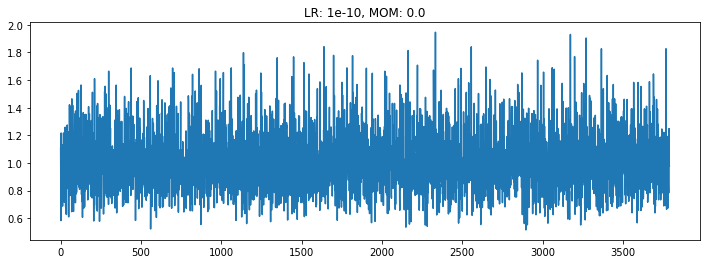

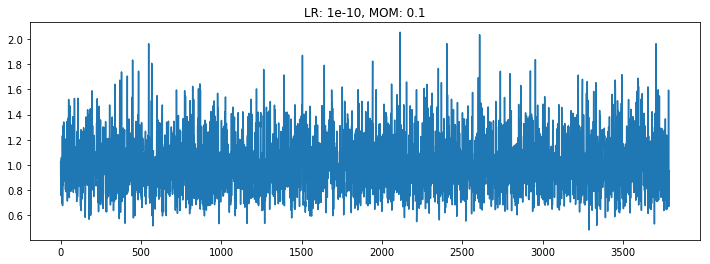

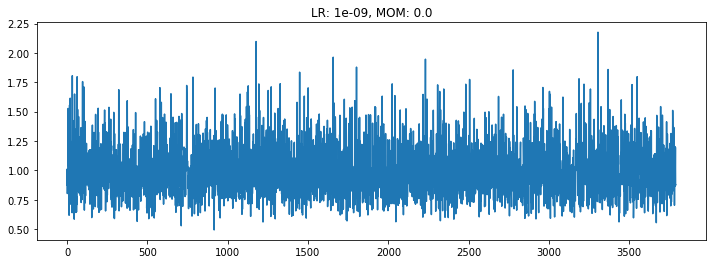

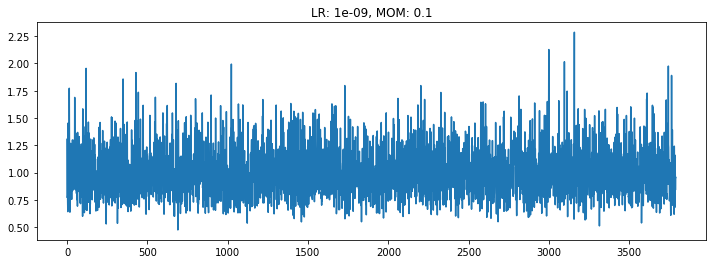

In [116]:
%%time

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

use_gpu = True

batch_size = 32
num_epochs = 10
stat_freq = 20

criterion = nn.MSELoss()

if use_gpu:
    test_inp_var = Variable(torch.Tensor(test_inputs), volatile=True).cuda()
else:
    test_inp_var = Variable(torch.Tensor(test_inputs), volatile=True)

for lr in 10.0 ** np.arange(-10, -8):
    for mom in np.arange(2)/10:
        model = MLP_autoencoder(
                encoder_sizes=[
                    img_size ** 2,
                    128,
                    64,
                    12
                ],
                decoder_sizes=[
                    12,
                    64,
                    128,
                    img_size ** 2
                ],
                activation='relu',
                final_activation='tanh'
            )

        if use_gpu:
            model.cuda()

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom, weight_decay=0)

        batches_processed = 0
        losses = []
        
        print(f'Training for lr={lr}, momentum={mom}')
        for epoch in range(num_epochs):
            for inputs, _ in train_data.get_image_batch_iterator(batch_size, img_as_vector=True):
                targets = torch.Tensor(inputs)
                if use_gpu:
                    inputs = Variable(inputs).cuda()
                    targets = Variable(targets).cuda()
                else:
                    inputs = Variable(inputs)
                    targets = Variable(targets)
                
                # Forward pass
                _, decoded = model(inputs)

                # Calculate loss
                loss = criterion(decoded, targets)
                losses.append(loss.data[0])

                # Compute gradients and update weights
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Logging
            print('epoch [{}/{}], loss:{:.4f}'
                  .format(epoch + 1, num_epochs, loss.data[0]))
            losses.append(loss.data[0])

            if epoch % 10 == 0:
                pic = to_img(output.cpu().data)
                save_image(pic, './mlp_img/image_{}.png'.format(epoch))
            
        
        
        test_loss = criterion(
            model(test_inp_var)[1],
            test_inp_var
        ).data[0]
        print(f'Test loss: {test_loss:.3f}')
        plt.figure(figsize=(12, 4))
        plt.title(f'LR: {lr}, MOM: {mom}')
        plt.plot(losses);

# Our autoencoder on MNIST

In [98]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

num_epochs = 10
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# model = autoencoder().cuda()
model = MLP_autoencoder(
    encoder_sizes=[
        img_size ** 2,
        128,
        64,
        12,
        3
    ],
    decoder_sizes=[
        3,
        12,
        64,
        128,
        img_size ** 2
    ],
    activation='relu',
    final_activation='tanh'
).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

losses = []

for epoch in range(num_epochs):
    for data in dataloader:#train_data.get_image_batch_iterator(batch_size, img_as_vector=True):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        _, output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0])
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/10], loss:0.1768
epoch [2/10], loss:0.1375
epoch [3/10], loss:0.1291
epoch [4/10], loss:0.1623
epoch [5/10], loss:0.1246
epoch [6/10], loss:0.1229
epoch [7/10], loss:0.1619
epoch [8/10], loss:0.1337
epoch [9/10], loss:0.1536
epoch [10/10], loss:0.1182


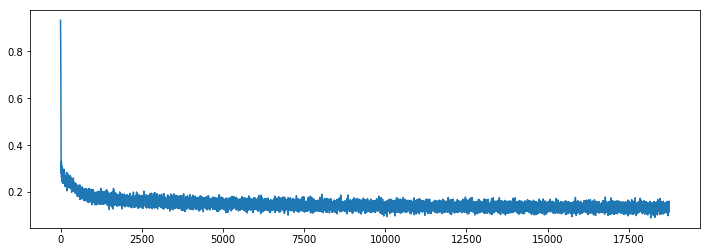

In [106]:
plt.figure(figsize=(12,4))
plt.plot(losses)